# Introduction to LangChain Expression Language (LCEL)

This Jupyter notebook introduces LangChain Expression Language (LCEL), a powerful syntax for composing language model workflows. LCEL aims to make it easier and more transparent to construct complex chains of operations involving language models.

## Key Concepts

1. **Runnables**: Components that can be executed, such as prompts, models, and parsers.
2. **Chains**: Sequences of runnables connected together.
3. **Fallbacks**: Alternative paths of execution if a primary path fails.
4. **Binding**: Attaching parameters or functions to runnables.

## Goals of this Notebook

- Demonstrate how to create simple and complex chains using LCEL
- Explain the benefits of using LCEL, including:
  - Built-in support for async, batch, and streaming operations
  - Easy attachment of fallbacks
  - Simplified parallelism for time-consuming operations
  - Built-in logging capabilities

## Target Audience

This notebook is designed for developers and data scientists familiar with Python and basic concepts of language models. While some prior experience with LangChain is helpful, the examples are explained step-by-step to accommodate newcomers.

## Structure

The notebook progresses from simple examples to more complex use cases, covering:

1. Creating a basic chain
2. Building a more complex chain with retrieval
3. Using the `bind` method for attaching functions
4. Implementing fallbacks
5. Exploring the LCEL interface (invoke, batch, stream, async methods)

In [11]:
%pip install --upgrade pip
%pip install -qU python-dotenv
%pip install -qU openai
%pip install -qU langchain
%pip install -qU langchain_community
%pip install -qU langchain-openai
%pip install -qU docarray

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import openai
import json

from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv())
openai.api_key = os.environ['OPENAI_API_KEY']

### Simple Chain

We start with a basic example of LCEL, constructing a chain that generates a short joke. This demonstrates the fundamental concept of piping components together:

prompt -> model -> output parser

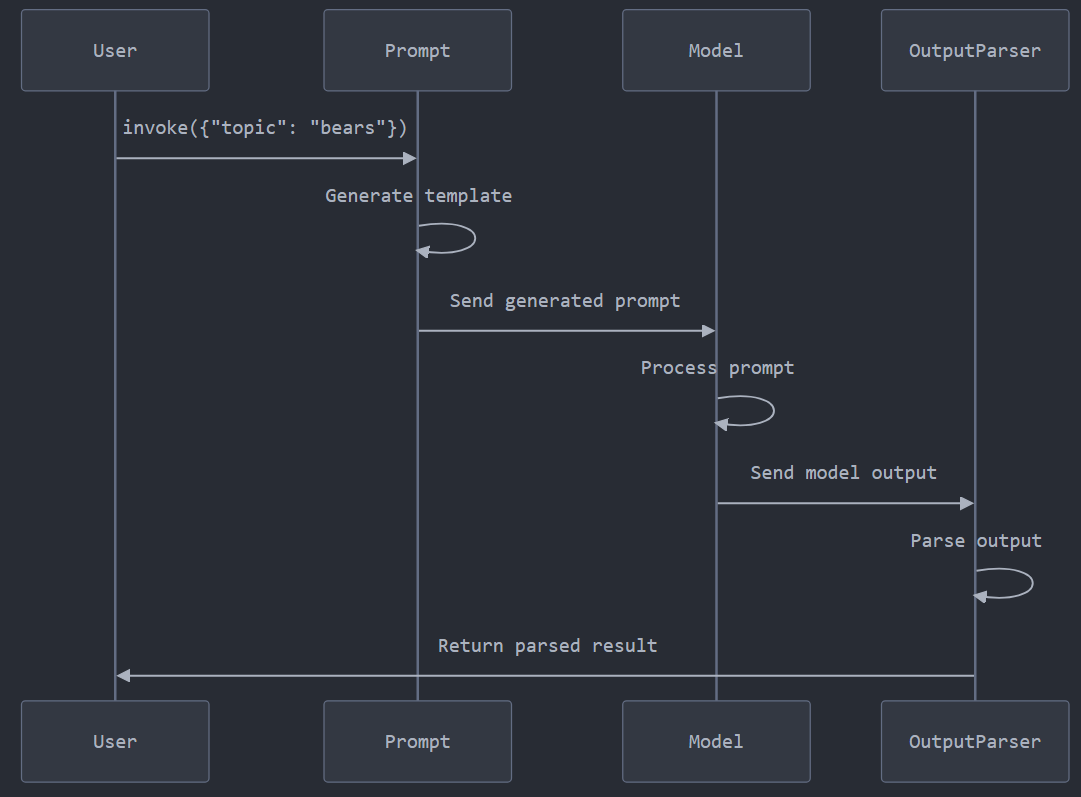

In [6]:
from langchain.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from langchain.schema import StrOutputParser


prompt = ChatPromptTemplate.from_template(
    "Tell me a short joke about {topic}"
)
model = ChatOpenAI(model="gpt-4o-mini")
output_parser = StrOutputParser()

chain = prompt | model | output_parser

chain.invoke({"topic": "bears"})

'Why do bears have hairy coats? \n\nBecause they look silly in sweaters!'

### Complex Chain with Retrieval

Building on the simple chain, we create a more advanced structure that incorporates a retriever for relevant documents. This showcases how to use `RunnableMap` to handle multiple inputs:

RunnableMap (context + question) -> prompt -> model -> output parser

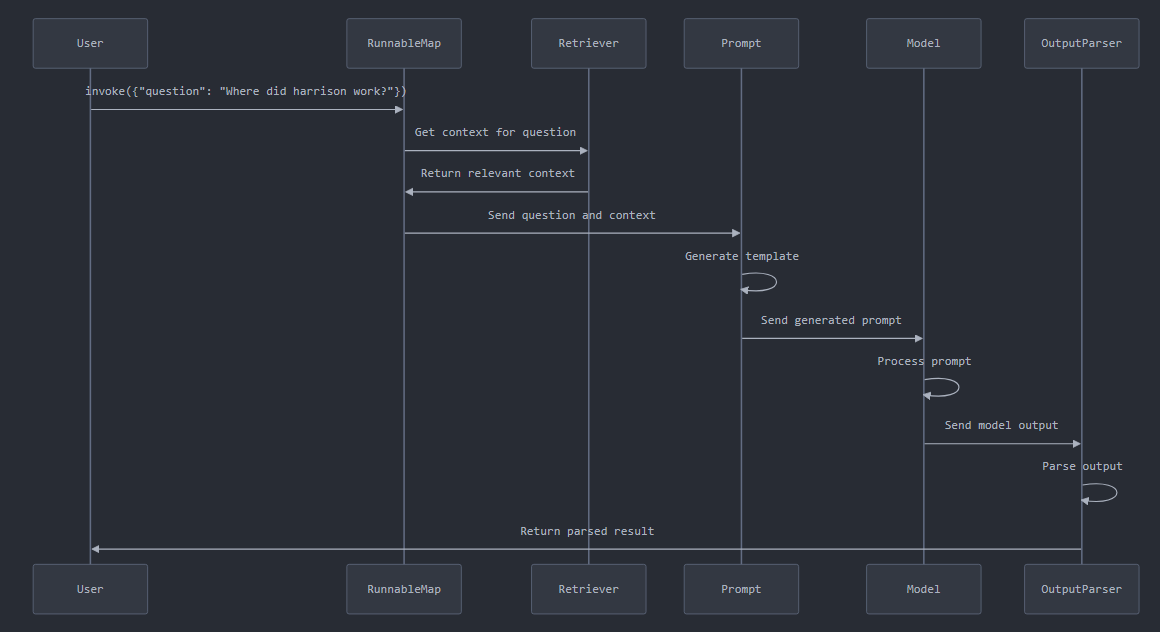

In [12]:
from langchain.embeddings import OpenAIEmbeddings
from langchain.vectorstores import DocArrayInMemorySearch

vector_store = DocArrayInMemorySearch.from_texts(
    ["harrison worked at kensho", "bears like to eat honey"],
    embedding=OpenAIEmbeddings()
)

retriever = vector_store.as_retriever()

/home/snack/large/venv/lib/python3.12/site-packages/pydantic/_migration.py:283: UserWarning: `pydantic.error_wrappers:ValidationError` has been moved to `pydantic:ValidationError`.
  warnings.warn(f'`{import_path}` has been moved to `{new_location}`.')


In [13]:
retriever.invoke("Where did harrison work?")

[Document(page_content='harrison worked at kensho'),
 Document(page_content='bears like to eat honey')]

In [14]:
retriever.invoke("What do bears like to eat?")

[Document(page_content='bears like to eat honey'),
 Document(page_content='harrison worked at kensho')]

#### RunnableMap in LangChain Expression Language (LCEL)

RunnableMap is a key component in LCEL for preprocessing and structuring input data before it reaches language models.

##### Key Concepts

1. **Input Processing**: Applies defined operations to input data.
2. **Lambda Functions**: Define operations for each output key.
3. **Structured Output**: Creates a new dictionary with processed data.

##### Benefits

- Combines user input with retrieved context
- Enables modular preprocessing
- Simplifies complex input preparation

##### Use Case

Particularly useful for combining user input with retrieved context (the Document search in this case) before passing to a language model.

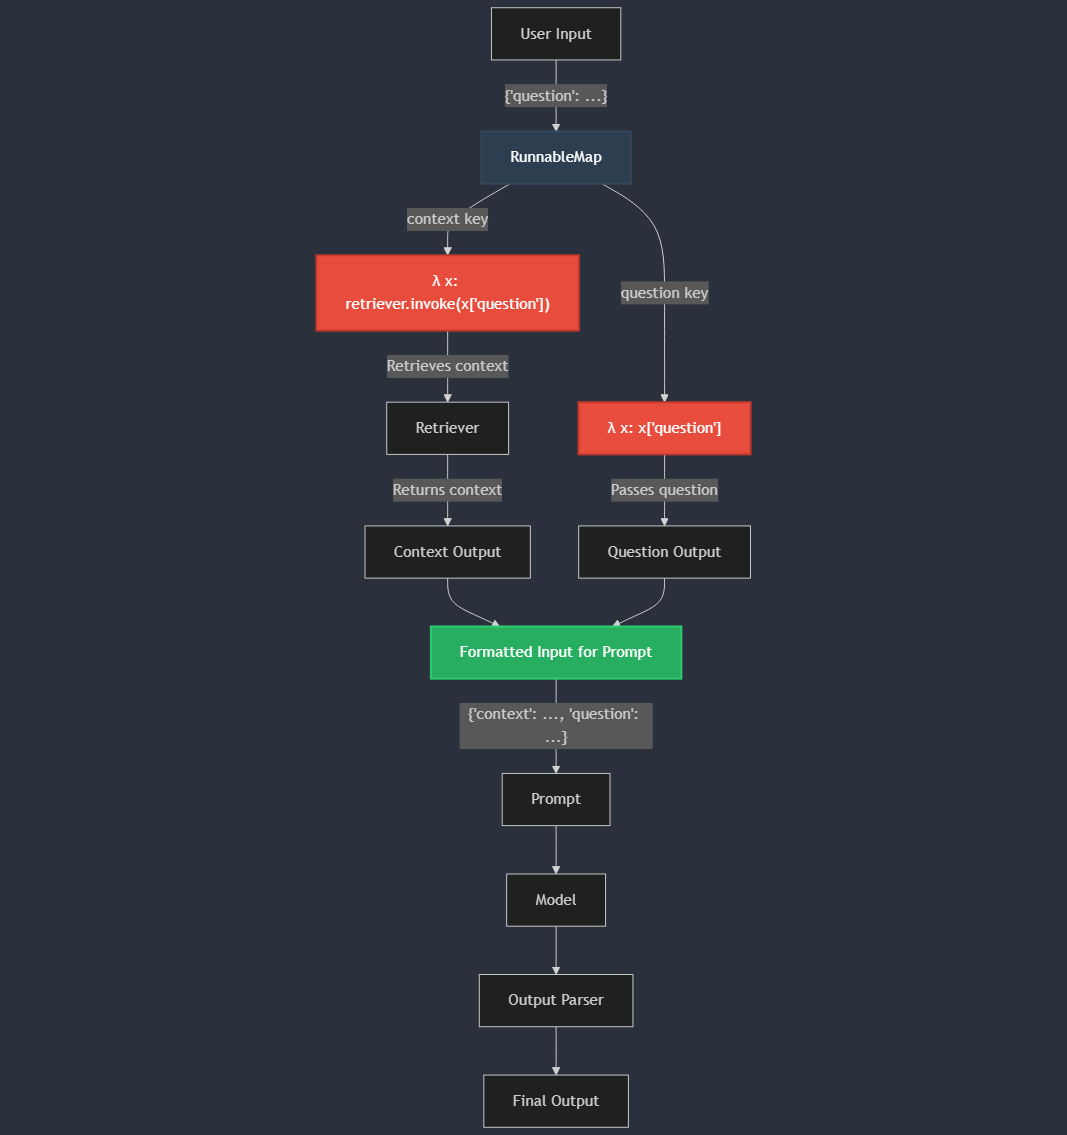

In [17]:
from langchain.schema.runnable import RunnableMap

template = """Answer the question based on the following context: {context} 

Question: {question}
"""
prompt = ChatPromptTemplate.from_template(template)

chain = RunnableMap({
    "context": lambda x: retriever.invoke(x["question"]),
    "question": lambda x: x["question"]
}) | prompt | model | output_parser

In [18]:
chain.invoke({"question": "Where did harrison work?"})

'Harrison worked at Kensho.'

In [19]:
inputs = RunnableMap({
    "context": lambda x: retriever.invoke(x["question"]),
    "question": lambda x: x["question"]
})

In [20]:
inputs.invoke({"question": "Where did harrison work?"})

{'context': [Document(page_content='harrison worked at kensho'),
  Document(page_content='bears like to eat honey')],
 'question': 'Where did harrison work?'}

### Binding Parameters

The `bind` method allows us to attach parameters or functions to runnables. We demonstrate this by binding OpenAI functions to a language model, showing how to extend model capabilities:

prompt -> model.bind(functions=...) -> output

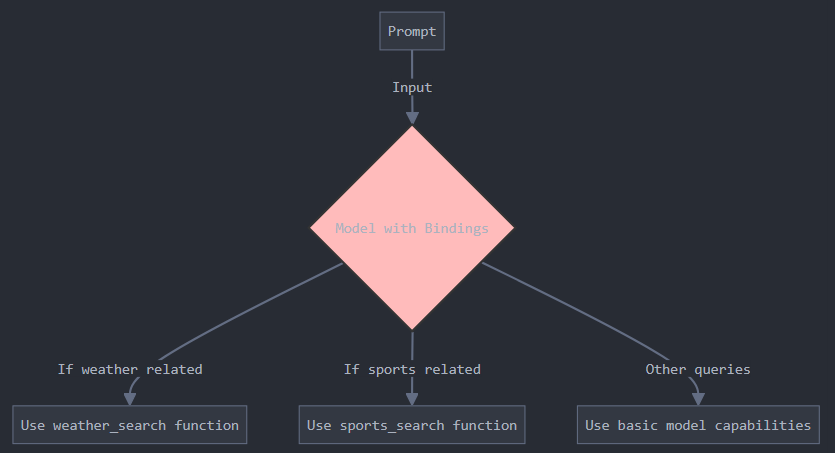

In [21]:
functions = [
    {
      "name": "weather_search",
      "description": "Search for weather given an airport code",
      "parameters": {
        "type": "object",
        "properties": {
          "airport_code": {
            "type": "string",
            "description": "The airport code to get the weather for"
          },
        },
        "required": ["airport_code"]
      }
    }
  ]

In [25]:
prompt = ChatPromptTemplate.from_messages(
    [
        ("human", "{input}")
    ]
)
model = ChatOpenAI(model="gpt-4o-mini",temperature=0).bind(functions=functions)

In [26]:
runnable = prompt | model

In [27]:
runnable.invoke({"input": "What is the weather in SF"})

AIMessage(content='', additional_kwargs={'function_call': {'arguments': '{"airport_code":"SFO"}', 'name': 'weather_search'}, 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 62, 'total_tokens': 78}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_f33667828e', 'finish_reason': 'function_call', 'logprobs': None}, id='run-da00fcc4-52c6-4a6d-8855-6edd9745a8c2-0', usage_metadata={'input_tokens': 62, 'output_tokens': 16, 'total_tokens': 78})

In [28]:
functions = [
    {
      "name": "weather_search",
      "description": "Search for weather given an airport code",
      "parameters": {
        "type": "object",
        "properties": {
          "airport_code": {
            "type": "string",
            "description": "The airport code to get the weather for"
          },
        },
        "required": ["airport_code"]
      }
    },
        {
      "name": "sports_search",
      "description": "Search for news of recent sport events",
      "parameters": {
        "type": "object",
        "properties": {
          "team_name": {
            "type": "string",
            "description": "The sports team to search for"
          },
        },
        "required": ["team_name"]
      }
    }
  ]

In [29]:
model = model.bind(functions=functions)

In [30]:
runnable = prompt | model

In [32]:
runnable.invoke({"input": "how did the patriots do yesterday"})

AIMessage(content='', additional_kwargs={'function_call': {'arguments': '{"team_name":"New England Patriots"}', 'name': 'sports_search'}, 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 94, 'total_tokens': 112}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_f33667828e', 'finish_reason': 'function_call', 'logprobs': None}, id='run-f58c8781-ce02-4b74-9311-a2542ef905a6-0', usage_metadata={'input_tokens': 94, 'output_tokens': 18, 'total_tokens': 112})

### Fallbacks

LCEL makes it easy to implement fallback strategies. We create a chain that attempts to use a simpler model first, falling back to a more capable model if needed:

simple_chain.with_fallbacks([advanced_chain])

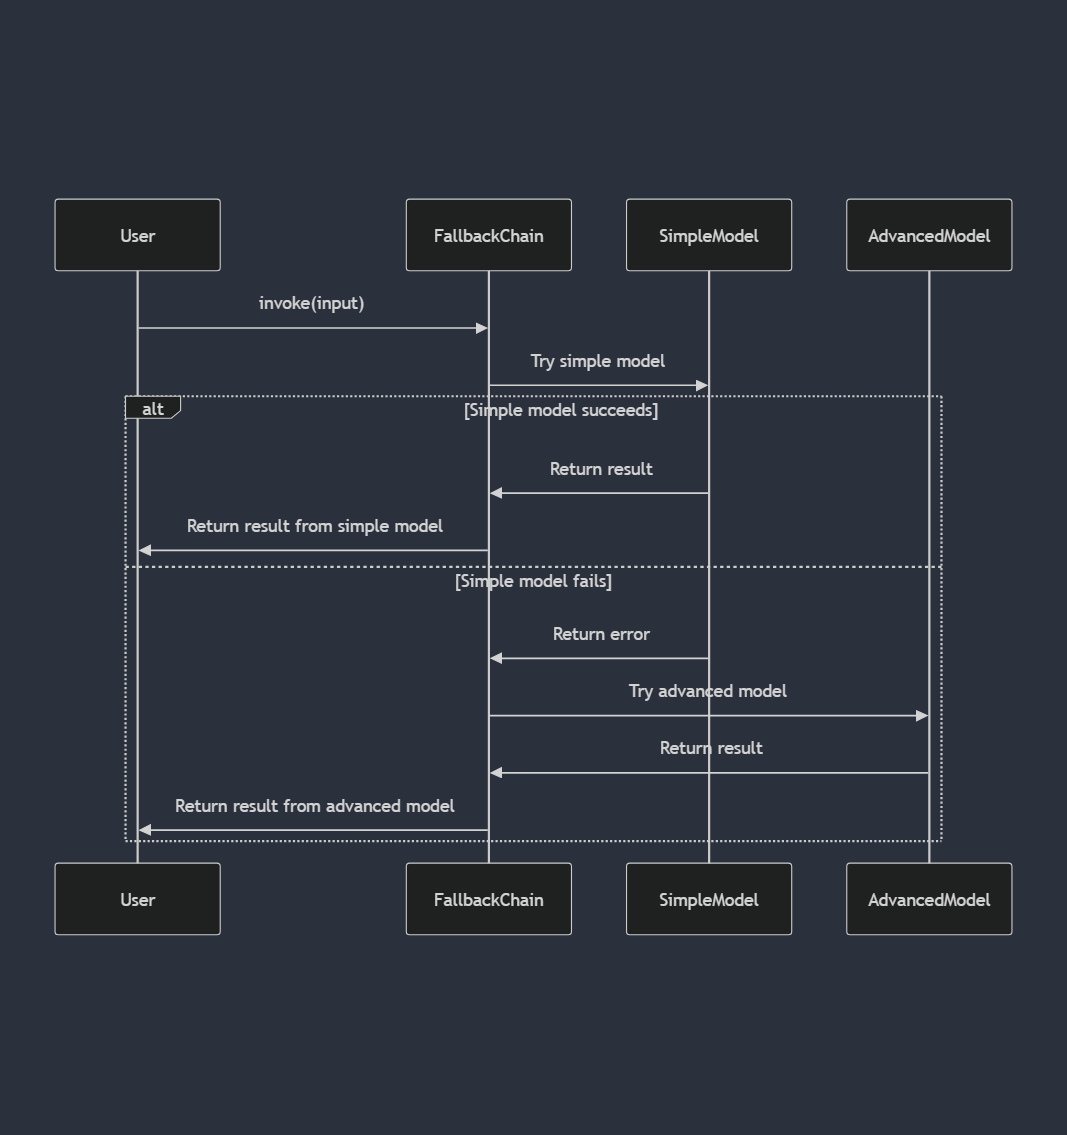

In [33]:
from langchain.llms import OpenAI
import json

In [34]:
simple_model = OpenAI(
    temperature=0, 
    max_tokens=1000, 
    model="gpt-3.5-turbo-instruct"
)
simple_chain = simple_model | json.loads

/tmp/ipykernel_165800/2498289737.py:1: LangChainDeprecationWarning: The class `OpenAI` was deprecated in LangChain 0.0.10 and will be removed in 1.0. An updated version of the class exists in the langchain-openai package and should be used instead. To use it run `pip install -U langchain-openai` and import as `from langchain_openai import OpenAI`.
  simple_model = OpenAI(


In [35]:
challenge = "write three poems in a json blob, where each poem is a json blob of a title, author, and first line"

In [36]:
simple_model.invoke(challenge)

'\n\n{\n    "title": "Autumn Leaves",\n    "author": "Emily Dickinson",\n    "first_line": "The leaves are falling, one by one"\n}\n\n{\n    "title": "The Ocean\'s Song",\n    "author": "Pablo Neruda",\n    "first_line": "I hear the ocean\'s song, a symphony of waves"\n}\n\n{\n    "title": "A Winter\'s Night",\n    "author": "Robert Frost",\n    "first_line": "The snow falls softly, covering the ground"\n}'

In [37]:
simple_chain.invoke(challenge) ## This should fail as the model being used is not very good at outputing json

JSONDecodeError: Extra data: line 9 column 1 (char 125)

In [51]:
# model = ChatOpenAI(model="gpt-4o",temperature=0) # Using gpt-4o and gpt-4o-mini models failed for me and did not produce valid json. I explore the new solution to this below.
model = ChatOpenAI(temperature=0) 
chain = model | StrOutputParser() | json.loads 

In [52]:
chain.invoke(challenge)

{'poem1': {'title': 'The Rose',
  'author': 'Emily Dickinson',
  'firstLine': 'A rose by any other name would smell as sweet'},
 'poem2': {'title': 'The Road Not Taken',
  'author': 'Robert Frost',
  'firstLine': 'Two roads diverged in a yellow wood'},
 'poem3': {'title': 'Hope is the Thing with Feathers',
  'author': 'Emily Dickinson',
  'firstLine': 'Hope is the thing with feathers that perches in the soul'}}

In [59]:
final_chain = simple_chain.with_fallbacks([chain])

In [60]:
final_chain.invoke(challenge)

{'poem1': {'title': 'The Rose',
  'author': 'Emily Dickinson',
  'first_line': 'A rose by any other name would smell as sweet'},
 'poem2': {'title': 'The Road Not Taken',
  'author': 'Robert Frost',
  'first_line': 'Two roads diverged in a yellow wood'},
 'poem3': {'title': 'Hope is the Thing with Feathers',
  'author': 'Emily Dickinson',
  'first_line': 'Hope is the thing with feathers that perches in the soul'}}

#### What are Structured Outputs?

Structured Outputs is a new feature from OpenAI that helps ensure AI responses follow a specific format. It's like giving the AI a template to fill out, making sure you get exactly the information you need in the way you want it. Structured Outputs is available on newer models (gpt-4o-mini and later), while JSON mode works on older models.

##### How is it different from the previous JSON mode?

1. **Stricter formatting:** 
   - JSON mode just made sure the AI gave you valid JSON.
   - Structured Outputs goes further. It makes sure the AI gives you JSON that matches the exact structure you ask for.

2. **Easier error handling:** 
   - With JSON mode, you often had to check if the AI included all the parts you wanted.
   - Structured Outputs does this checking for you. If something's missing, it tells you right away.

3. **Safety responses:** 
   - Sometimes, AI might refuse to answer for safety reasons.
   - Structured Outputs has a special way to tell you when this happens, making it easier to handle in your code.

4. **Works on newer AI models:** 
   - JSON mode worked on many AI models.
   - Structured Outputs only works on the newest models (like gpt-4o-mini and newer), but it works better.

##### Do I need to define a schema class?

You don't absolutely have to, but it's a really good idea. Here's why:

1. **It makes your code clearer:** A schema class shows exactly what you expect from the AI.
2. **It can catch errors early:** If you use certain types of schemas (like Pydantic), they can automatically check if the AI's response is correct.
3. **It helps the AI understand better:** The more clearly you explain what you want, the more likely the AI is to give it to you.

You have three main ways to define your schema:

1. **Pydantic classes:** This is often the best choice. It's easy to read and automatically checks the AI's response.
2. **TypedDict classes:** This is a bit simpler but doesn't check the response automatically.
3. **JSON Schema dictionaries:** This gives you the most control but can be more complicated to write.

##### A Basic Example Using LangChain

Here's a simple example of how to use Structured Outputs with LangChain:

```python

In [58]:

from langchain_openai import ChatOpenAI
from langchain_core.pydantic_v1 import BaseModel, Field

# Define the structure we want
class WeatherReport(BaseModel):
    temperature: float = Field(description="The temperature in Celsius")
    condition: str = Field(description="The weather condition (e.g., sunny, rainy)")
    humidity: int = Field(description="The humidity percentage")

# Set up our AI model
llm = ChatOpenAI(model="gpt-4o-mini")

# Tell the AI to use our WeatherReport structure
structured_llm = llm.with_structured_output(WeatherReport)

# Ask for a weather report
result = structured_llm.invoke("What's the weather like in New York today?")

# Display the raw JSON
print("Raw JSON output:")
print(json.dumps(result.dict(), indent=2))

# Now use the structured data
print("\nStructured data:")
print(f"Temperature: {result.temperature}°C")
print(f"Condition: {result.condition}")
print(f"Humidity: {result.humidity}%")

Raw JSON output:
{
  "temperature": 18.0,
  "condition": "sunny",
  "humidity": 60
}

Structured data:
Temperature: 18.0°C
Condition: sunny
Humidity: 60%


In this example:
1. We define a `WeatherReport` class that describes exactly what information we want.
2. We create an AI model and tell it to use our `WeatherReport` structure.
3. When we ask about the weather, the AI will always give us the temperature, condition, and humidity, no matter how it phrases its response.

This makes it much easier to use the AI's response in your code, because you know exactly what information you'll get and in what format.

##### Why Use Structured Outputs?

1. **Consistency:** You always get the same type of information in the same format.
2. **Ease of use:** It's easier to work with the AI's responses in your code.
3. **Fewer errors:** You're less likely to get unexpected data that could break your application.
4. **Clear communication:** It helps you tell the AI exactly what you want, leading to more accurate responses.

Structured Outputs is a powerful tool that can make working with AI responses much smoother and more reliable.

### LCEL Interface

Finally, we explore the various methods provided by the LCEL interface, including:
- `invoke`: for single synchronous calls
- `batch`: for parallel processing of multiple inputs
- `stream`: for streaming responses
- `ainvoke`: for asynchronous operations

These methods provide flexibility in how you interact with your chains.

In [63]:
prompt = ChatPromptTemplate.from_template(
    "tell me a short joke about {topic}"
)
model = ChatOpenAI(model="gpt-4o-mini")
output_parser = StrOutputParser()

chain = prompt | model | output_parser

In [64]:
chain.invoke({"topic": "bears"})

'Why did the bear sit on the log? \n\nBecause it wanted to be a "bear-y" comfortable seat!'

In [65]:
chain.batch([{"topic": "bears"}, {"topic": "frogs"}])

['Why do bears have hairy coats? \n\nBecause they look silly in sweaters!',
 'What do you call a frog with no hind legs? \n\nUnhoppy!']

In [66]:
for t in chain.stream({"topic": "bears"}):
    print(t)


Why
 do
 bears
 have
 hairy
 coats
?
 


Because
 they
 look
 silly
 in
 sweaters
!



In [67]:
response = await chain.ainvoke({"topic": "bears"})
response

'Why do bears have hairy coats? \n\nBecause they look silly in sweaters!'